In [6]:
## 1- Data Exploration
### A- get historical values
### B- plot Adjusted Close column
### C- check for null values

#A- get historical values

import pandas as pd
import pandas_datareader as pdr
import datetime

stock_list = ['TUPRS.IS', 'EREGL.IS', 'EGEEN.IS', 'BAGFS.IS','ULUSE.IS']

start=datetime.datetime(2010,3,20)

end=datetime.datetime(2020,1,31)

for stock in stock_list:
    history = pdr.get_data_yahoo(stock, start, end)
    history.to_csv('./data1/'+stock+'.csv')

TUPRS = pd.read_csv('data1/TUPRS.IS.csv', header=0, parse_dates=['Date'])
TUPRS.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-03-22,32.50,31.50,32.25,32.25,963359.0,15.438827
1,2010-03-23,32.50,32.00,32.00,32.00,589401.0,15.319145
2,2010-03-24,32.75,32.00,32.00,32.00,756058.0,15.319145
3,2010-03-25,32.75,32.00,32.25,32.25,919227.0,15.438827
4,2010-03-26,33.50,32.25,33.25,33.25,1296865.0,15.917545


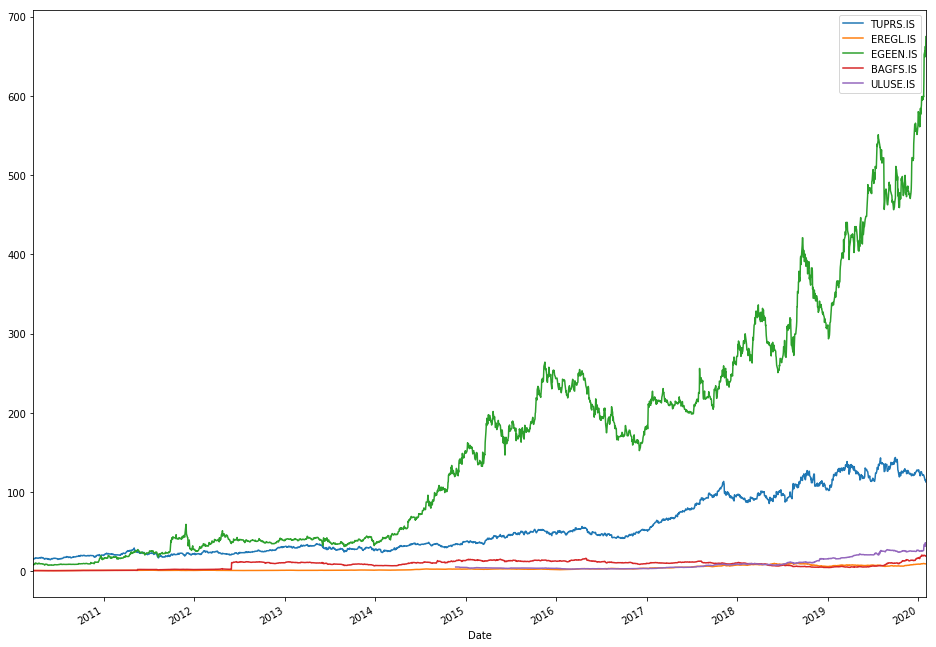

In [7]:
# B- plot Adjusted Close column

import datetime
import matplotlib as plt

stock_data_list = []

for stock in stock_list:
    stock_data = pd.read_csv('data1/'+stock+'.csv', header=0, parse_dates=['Date'])
    stock_data.set_index('Date',inplace=True)
    plott = stock_data['Adj Close'].plot(figsize=(16, 12), label=stock)
    plott.legend()
    stock_data['stock_name'] = stock
    stock_data_list.append(stock_data)



# C- check for null values
there_exist_null_value = False

for stock_data in stock_data_list:
    there_exist_null_value = there_exist_null_value or stock_data.isnull().any().any()

print(there_exist_null_value)

## 2- Domain Research
### A- Add Key Feature Columns to Data
### B- Plot Examples for Key Features

In [19]:
#A- Add Key Feature Columns to Data
import numpy as np
#Add MACD 26, 12 day periods
def add_MACD(dataframe):
    macd26 = dataframe['Adj Close'].ewm(span=26, min_periods=26, adjust= True).mean()
    macd12 = dataframe['Adj Close'].ewm(span=12, min_periods=12, adjust= True).mean()
    dataframe["MACD"] = macd26-macd12
    return dataframe

#Add RSI Wilder's RSI
def add_RSI(df, column='Adj Close', period=14):
    delta = df[column].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=period - 1,  adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)    
    return df.join(rsi.to_frame('RSI'))

#Add Bollinger Bands
def add_BollingerBand(df, column='Adj Close', period=20):
    sma = df[column].rolling(window=period, min_periods=period - 1).mean()
    std = df[column].rolling(window=period, min_periods=period - 1).std()

    up = (sma + (std * 2)).to_frame('BBANDUP')
    lower = (sma - (std * 2)).to_frame('BBANDLO')
    return df.join(up).join(lower)

def get_weighted_average(dataframe,window,columnname_data,columnname_weights):
    processed_dataframe=dataframe.loc[:,(columnname_data,columnname_weights)].set_index(columnname_weights)   
    def get_mean_withweights(processed_dataframe_windowed):
        return np.average(a=processed_dataframe_windowed,weights=processed_dataframe_windowed.index)
    tmp_df = processed_dataframe.rolling(window=window).apply(func=get_mean_withweights,raw=False)
    tmp_df = tmp_df.reset_index()
    dataframe = dataframe.reset_index()
    tmp_df2 = dataframe.join(tmp_df['Adj Close'].to_frame('WMA'))
    tmp_df2.set_index('Date',inplace=True)
    #print(tmp_df2)
    return tmp_df2


for index, stock_data in enumerate(stock_data_list):
    stock_data = add_MACD(stock_data)
    stock_data = add_RSI(stock_data)
    stock_data = add_BollingerBand(stock_data)
    stock_data = get_weighted_average(stock_data,10,'Adj Close', 'Volume')
    #print(stock_data.columns)
    #print(stock_data)
    #stock_data['MACD'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['RSI'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDUP'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDLO'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['WMA'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    stock_data = stock_data[25:] #delete NaN values
    stock_data_list[index] = stock_data

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'stock_name',
       'MACD', 'RSI', 'BBANDUP', 'BBANDLO', 'WMA'],
      dtype='object')


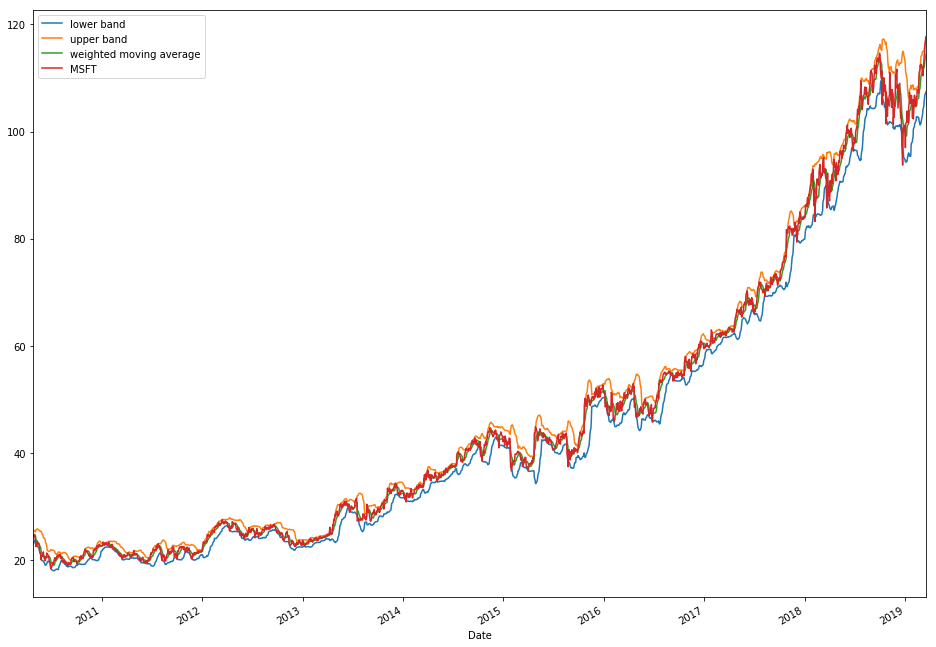

In [20]:
def plot_stock(index):
    stock_data = stock_data_list[index]
    print(stock_data.columns)

    #plot Bollinger Bands
    plt1 = stock_data['BBANDLO'].plot(figsize=(16, 12), label='lower band')
    stock_data['BBANDUP'].plot(label='upper band')
    stock_data['WMA'].plot(label='weighted moving average')
    stock_data['Adj Close'].plot(label=stock_data['stock_name'][0])
    plt1.legend()
    
plot_stock(5)



#plot RSI and MACD
#plot2 =  stock_data['RSI'].plot(figsize=(16, 12), label='RSI')

## 2- Data Normalization & Seperation

In [21]:
from sklearn import preprocessing

def normalize_data(n_stock_list):
    scaler = preprocessing.MinMaxScaler()
    normalized_stock_list = []
    y_adj_close_list = []
    for stock_data in n_stock_list:
        stock_data = stock_data.drop(columns='stock_name')

        names = stock_data.columns
        scaled_df = scaler.fit_transform(stock_data)
        scaled_df = pd.DataFrame(scaled_df, columns=names)
        #scale adjusted price to 100
        scaled_df['Adj Close'] = scaled_df['Adj Close'].apply(lambda x: x*100)


        y_adj_close_list.append(scaled_df['Adj Close'])
        scaled_df = scaled_df.drop(columns='Adj Close')

        normalized_stock_list.append(scaled_df)
    return normalized_stock_list, y_adj_close_list

#since we want n+1 adj close price to be predicted with the n th day values
#we need to shift y values for 1 day 
def shift_data_one_day(y_adj_close_list):
    for y_adj_close in y_adj_close_list:
        y_adj_close.shift(-1)




normalized_stock_list, y_adj_close_list = normalize_data(stock_data_list)
shift_data_one_day(y_adj_close_list)
    
#print(y_adj_close_list[5]) # our target list to predict  
#print(normalized_stock_list[5]) # our input values for models  
   


/home/ai/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## 3- Building:
### A: Benchmark Model
### B: RMSE and R2 Validation
### C: Solution Model
### D: Test Flow


In [22]:
# A- For Benchmark we will use standard linear regression
from keras.layers import Dense
from keras.models import Model, Sequential
from keras import initializers, optimizers
from sklearn.model_selection import train_test_split

from pylab import *


def create_benchmark_model():
   model = Sequential()
   model.add(Dense(1, activation = 'linear', input_dim = 10))
   sgd = optimizers.SGD(lr=0.2)
   model.compile(optimizer = sgd, loss = 'mean_squared_error', metrics = ['accuracy'])
   return model

# B - RMSE Score, R2 Score
from sklearn.metrics import mean_squared_error, r2_score


def RMSE_score(y, y_predicted, method_name):
    RMSE_score = np.sqrt(mean_squared_error(y, y_predicted))
    print(method_name + " RMSE Score: {0}".format(RMSE_score))
    return RMSE_score


def R2_score(y, y_predicted, method_name):
    R2_score = r2_score(y, y_predicted)
    print( method_name +" R2 Score: {0}".format(R2_score))
    return R2_score

def check_score(y, y_predicted, method_name):
    rmse = RMSE_score(y, y_predicted, method_name)
    r2 = R2_score(y, y_predicted, method_name)
    return rmse, r2


In [23]:
# C - Solution Models LSTM and SVM 
from sklearn import svm
from keras.layers.recurrent import LSTM
from keras.layers import Dropout, Activation, Flatten
import numpy 

def create_svm_linear_model():
    model = svm.SVR(kernel='linear', C=100)
    return model

def create_svm_polynomial_model():
    model = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
    return model

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(return_sequences=True, input_shape=(1, 10), units=100, dropout=0.2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mse', optimizer='rmsprop')
    return model

def create_svm_poly_with_parameters(_c = 100, _gamma ='auto', _epsilon=0.1, _degree=3, _coeff0=1):
    model = svm.SVR(kernel='poly', C=_c, gamma=_gamma, degree=_degree, epsilon=_epsilon, coef0=_coeff0)
    return model
       

In [24]:
#D -Test Flow

def drive_test(use_different_models):
    results_dataframe = pd.DataFrame()
    
    for index, normalized_stock in enumerate(normalized_stock_list):
        #below line is for only development stage to keep run time short
        #if(index > 3): break
        #create models
        if (use_different_models or index == 0):
            linear_regression_model = create_benchmark_model() 
            svm_linear = create_svm_linear_model()
            svm_polynomial = create_svm_polynomial_model()
            lstm_model = create_lstm_model()
        linear_regression_model = create_benchmark_model() 
        svm_linear = create_svm_linear_model()
        svm_polynomial = create_svm_polynomial_model()
        lstm_model = create_lstm_model()
        #split data
        X_train, X_test, y_train, y_test = train_test_split(normalized_stock_list[index], 
                                        y_adj_close_list[index], test_size=0.20, random_state=42)

        linear_regression_model.fit(X_train, y_train, epochs =100,batch_size = 32)
        linear_y_predict = linear_regression_model.predict(X_test)


        svm_linear.fit(X_train, y_train)
        svm_linear_y_predict = svm_linear.predict(X_test)


        svm_polynomial.fit(X_train, y_train)
        svm_polynomial_y_predict = svm_polynomial.predict(X_test)

        trainX = numpy.reshape(X_train.values, (X_train.shape[0],1, -1))
        testX = numpy.reshape(X_test.values, (X_test.shape[0],1, X_test.shape[1]))
        lstm_model.fit(trainX, y_train, batch_size =32,epochs = 1000)
        lstm_y_predict = lstm_model.predict(testX)

        rmse_1, r2_1 = check_score(y_test, linear_y_predict, "Linear Regression")
        rmse_2, r2_2 = check_score(y_test, svm_linear_y_predict, "SVM Linear Model")
        rmse_3, r2_3 = check_score(y_test, svm_polynomial_y_predict, "SVM Polynomial Model")
        rmse_4, r2_4 = check_score(y_test, lstm_y_predict, "LSTM Model")

        print(index )

        df = pd.DataFrame({"linear_rmse": rmse_1,  "linear_r2": r2_1, 
                                   "svm_linear_rmse":rmse_2, "svm_linear_r2":r2_2,
                                   "svm_polynomial_rmse":rmse_3, "svm_polynomial_r2":r2_3,
                                   "lstm_rmse":rmse_4, "lstm_r2":r2_4 }, index=[index])

        results_dataframe = results_dataframe.append(df)
    return results_dataframe

In [25]:
#drive the test flow and display results
#results_different_models = drive_test(True)
#result_same_models = drive_test(False)
#display(results_different_models)
#display(result_same_models)

In [26]:
#plot rmse of methods
def plot_method(frame1, frame2, method, title):
    #drop r2 columns
    cols = [c for c in frame1.columns if method in c]
    rmse_results1 =frame1[cols]
    rmse_results2=frame2[cols]
    plot_bar(title, rmse_results1)
    plot_bar()

def plot_bar(title, dataframe):
    df = dataframe.mean(axis=0)
    objects = dataframe.columns
    y_pos = np.arange(len(objects))
    plt.barh(y_pos, df , align='center', alpha=0.7)
    plt.yticks(y_pos, objects)
    #plt.xlabel(title)
    plt.title(title)
    plt.show()

#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(40, 60))


#plot_method(results_different_models, result_same_models, "rmse", "Different Models RMSE")
#plot_method(result_same_models, "rmse", "Same Models RMSE")

#plot_method(results_different_models, "r2", "Different Models R2")
#plot_method(result_same_models, "r2", "Sma Models R2")

In [27]:
#optimize SVR Solution

#Only SVR Polynomial with different parameters
def drive_test_2():
    results_rmse = pd.DataFrame()
    results_r2 = pd.DataFrame()
    
    for index, normalized_stock in enumerate(normalized_stock_list):
        #below line is for only development stage to keep run time short
        #if(index > 3): break
        #create models
        #split data
        X_train, X_test, y_train, y_test = train_test_split(normalized_stock_list[index], 
                                        y_adj_close_list[index], test_size=0.20, random_state=42)

        svm_polynomial = create_svm_poly_with_parameters()
        svm_polynomial.fit(X_train, y_train)
        svm_polynomial_y_predict = svm_polynomial.predict(X_test)
        rmse_1, r2_1 = check_score(y_test, svm_polynomial_y_predict, "Default")
        
        model_c200 = create_svm_poly_with_parameters(_c=200)
        model_c200.fit(X_train, y_train)
        model_c200_predict = model_c200.predict(X_test)
        rmse_c200, r2_c200 = check_score(y_test, model_c200_predict, "C200")

        model_c50 = create_svm_poly_with_parameters(_c=50)
        model_c50.fit(X_train, y_train)
        model_c50_predict = model_c50.predict(X_test)
        rmse_c50, r2_c50 = check_score(y_test, model_c50_predict, "C50")
        
        model_gamma_dot2 = create_svm_poly_with_parameters(_gamma=0.2)
        model_gamma_dot2.fit(X_train, y_train)
        model_gamma_dot2_predict = model_gamma_dot2.predict(X_test)
        rmse_gamma_dot2, r2_gamma_dot2 = check_score(y_test, model_gamma_dot2_predict, "gamma 0.2")
        
        model_gamma_dot8 = create_svm_poly_with_parameters(_gamma=0.8)
        model_gamma_dot8.fit(X_train, y_train)
        model_gamma_dot8_predict = model_gamma_dot8.predict(X_test)
        rmse_gamma_dot8, r2_gamma_dot8 = check_score(y_test, model_gamma_dot8_predict, "gamma 0.8")
        
        model_gamma_degree4 = create_svm_poly_with_parameters(_gamma=0.8, _c=200, _degree=4)
        model_gamma_degree4.fit(X_train, y_train)
        model_gamma_degree4_predict = model_gamma_degree4.predict(X_test)
        rmse_degree4, r2_degree4 = check_score(y_test, model_gamma_degree4_predict, "degree 4")

        print(index)
        df_rmse = pd.DataFrame({"default":rmse_1, "c200":rmse_c200, "c50":rmse_c50,
                                  "gamma_dot2":rmse_gamma_dot2, "rmse_gamma_dot8": rmse_gamma_dot8,
                                    "degree4":rmse_degree4 }, index=[index])
        
        df_r2 = pd.DataFrame({"default":r2_1, "c200":r2_c200, "c50":r2_c50,
                                 "gamma_dot2":r2_gamma_dot2, "gamma_dot8":r2_gamma_dot8,
                                 "degree4":r2_degree4}, index=[index])
        

        results_rmse = results_rmse.append(df_rmse)
        results_r2 = results_r2.append(df_r2)
    display(results_rmse.mean())
    display(results_r2.mean())
    return

#drive_test_2()





In [28]:
#Best model and benchmark comparison
#Only SVR Polynomial with different parameters
def drive_test_3():
    results_rmse = pd.DataFrame()
    results_r2 = pd.DataFrame()
    
    for index, normalized_stock in enumerate(normalized_stock_list):
        #below line is for only development stage to keep run time short
        #if(index > 3): break
        #create models
        #split data
        X_train, X_test, y_train, y_test = train_test_split(normalized_stock_list[index], 
                                        y_adj_close_list[index], test_size=0.20, random_state=42)
        
        linear_regression_model = create_benchmark_model() 
        linear_regression_model.fit(X_train, y_train, epochs =100,batch_size = 32)
        linear_y_predict = linear_regression_model.predict(X_test)

        rmse_benchmark, r2_benchmark = check_score(y_test, linear_y_predict, "Linear Regression")
        
        
        model_best = create_svm_poly_with_parameters(_gamma=0.8, _c=200, _degree=4)
        model_best.fit(X_train, y_train)
        model_best_predict = model_best.predict(X_test)
        rmse_best, r2_best = check_score(y_test, model_best_predict, "best SVR")

        print(index)
        df_rmse = pd.DataFrame({"best":rmse_best, "benchmark":rmse_benchmark}, index=[index])
                
        df_r2 = pd.DataFrame({"best":r2_best, "benchmark":r2_benchmark}, index=[index])
        

        results_rmse = results_rmse.append(df_rmse)
        results_r2 = results_r2.append(df_r2)
    display(results_rmse.mean())
    display(results_r2.mean())
    return

#drive_test_3()





In [14]:
#Visualization of SVR with recent data

def prepare_new_data():
    start=datetime.datetime(2010,3,20)
    end=datetime.datetime(2019,4,20)

    #for stock in stock_list:
    #    history = pdr.get_data_yahoo(stock, start, end)
    #    history.to_csv('~/src/udacity/stock_price_indicator/newdata/'+stock+'.csv')

    new_stock_data_list = []

    for stock in stock_list:
        stock_data = pd.read_csv('newdata/'+stock+'.csv', header=0, parse_dates=['Date'])
        stock_data.set_index('Date',inplace=True)
        stock_data['stock_name'] = stock
        new_stock_data_list.append(stock_data)

    for index, stock_data in enumerate(new_stock_data_list):
        stock_data = add_MACD(stock_data)
        stock_data = add_RSI(stock_data)
        stock_data = add_BollingerBand(stock_data)
        stock_data = get_weighted_average(stock_data,10,'Adj Close', 'Volume')
        stock_data = stock_data[25:] #delete NaN values
        new_stock_data_list[index] = stock_data    
        
    new_normalized_stock_list, new_y_adj_close_list = normalize_data(new_stock_data_list)
    old_normalized_stock_list = []
    old_y_adj_close_list = []
    
    shift_data_one_day(new_y_adj_close_list)
 
    for index, stck in enumerate(new_normalized_stock_list):
        stck_old = stck[:-30]
        old_normalized_stock_list.append(stck_old)
        stck_new = stck.tail(30) #get last 30 rows
        new_normalized_stock_list[index] = stck_new
        
    for index, adj_price in enumerate(new_y_adj_close_list):
        adj_old = adj_price[:-30]
        old_y_adj_close_list.append(adj_old)
        adj_price = adj_price.tail(30) #get last 30 rows
        new_y_adj_close_list[index] = adj_price
    
    return new_normalized_stock_list, new_y_adj_close_list, old_normalized_stock_list, old_y_adj_close_list

def drive_test_4(old_stck_list, new_stck_list, old_y_list, new_y_list):
    y_predict_list = []
    rmse_list = []
    r2_list = []
    for index, normalized_stock in enumerate(old_stck_list):
        X_train = old_stck_list[index]
        X_test = new_stck_list[index]
        y_train = old_y_list[index]
        y_test = new_y_list[index]
      
        model_best = create_svm_poly_with_parameters(_gamma=0.8, _c=200, _degree=4)
        model_best.fit(X_train, y_train)
        model_best_predict = model_best.predict(X_test)
        rmse_best, r2_best = check_score(y_test, model_best_predict, "best SVR")
        rmse_list.append(rmse_best)
        r2_list.append(r2_best)
        y_predict_list.append(model_best_predict)
    return y_predict_list, rmse_list, r2_list

new_normalized_stock_list, new_y_adj_close_list, \
old_normalized_stock_list, old_y_adj_close_list = prepare_new_data()

y_predict_list, rmse_list, r2_list = drive_test_4(old_normalized_stock_list, new_normalized_stock_list,old_y_adj_close_list, new_y_adj_close_list)



/home/ai/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


best SVR RMSE Score: 0.9300159997153311
best SVR R2 Score: 0.9347667213590383
best SVR RMSE Score: 0.065332573031268
best SVR R2 Score: 0.9996255687565369
best SVR RMSE Score: 2.6058469515507823
best SVR R2 Score: 0.7604536840724959
best SVR RMSE Score: 1.410661743691717
best SVR R2 Score: 0.8539392823162829
best SVR RMSE Score: 0.10050096106551812
best SVR R2 Score: 0.9978655837788089
best SVR RMSE Score: 0.9552225920552928
best SVR R2 Score: 0.8717583405987064
best SVR RMSE Score: 0.2580202693575619
best SVR R2 Score: 0.9951966649296532
best SVR RMSE Score: 1.2919853135967858
best SVR R2 Score: 0.9042950054833923
best SVR RMSE Score: 0.47357492700703874
best SVR R2 Score: 0.9613942387040463
best SVR RMSE Score: 1.3173681444807603
best SVR R2 Score: 0.986217785816174
best SVR RMSE Score: 1.1139106877473033
best SVR R2 Score: 0.9141439057468563
best SVR RMSE Score: 0.2794554955448494
best SVR R2 Score: 0.9824996571378722
best SVR RMSE Score: 0.5076701029912808
best SVR R2 Score: 0.9646

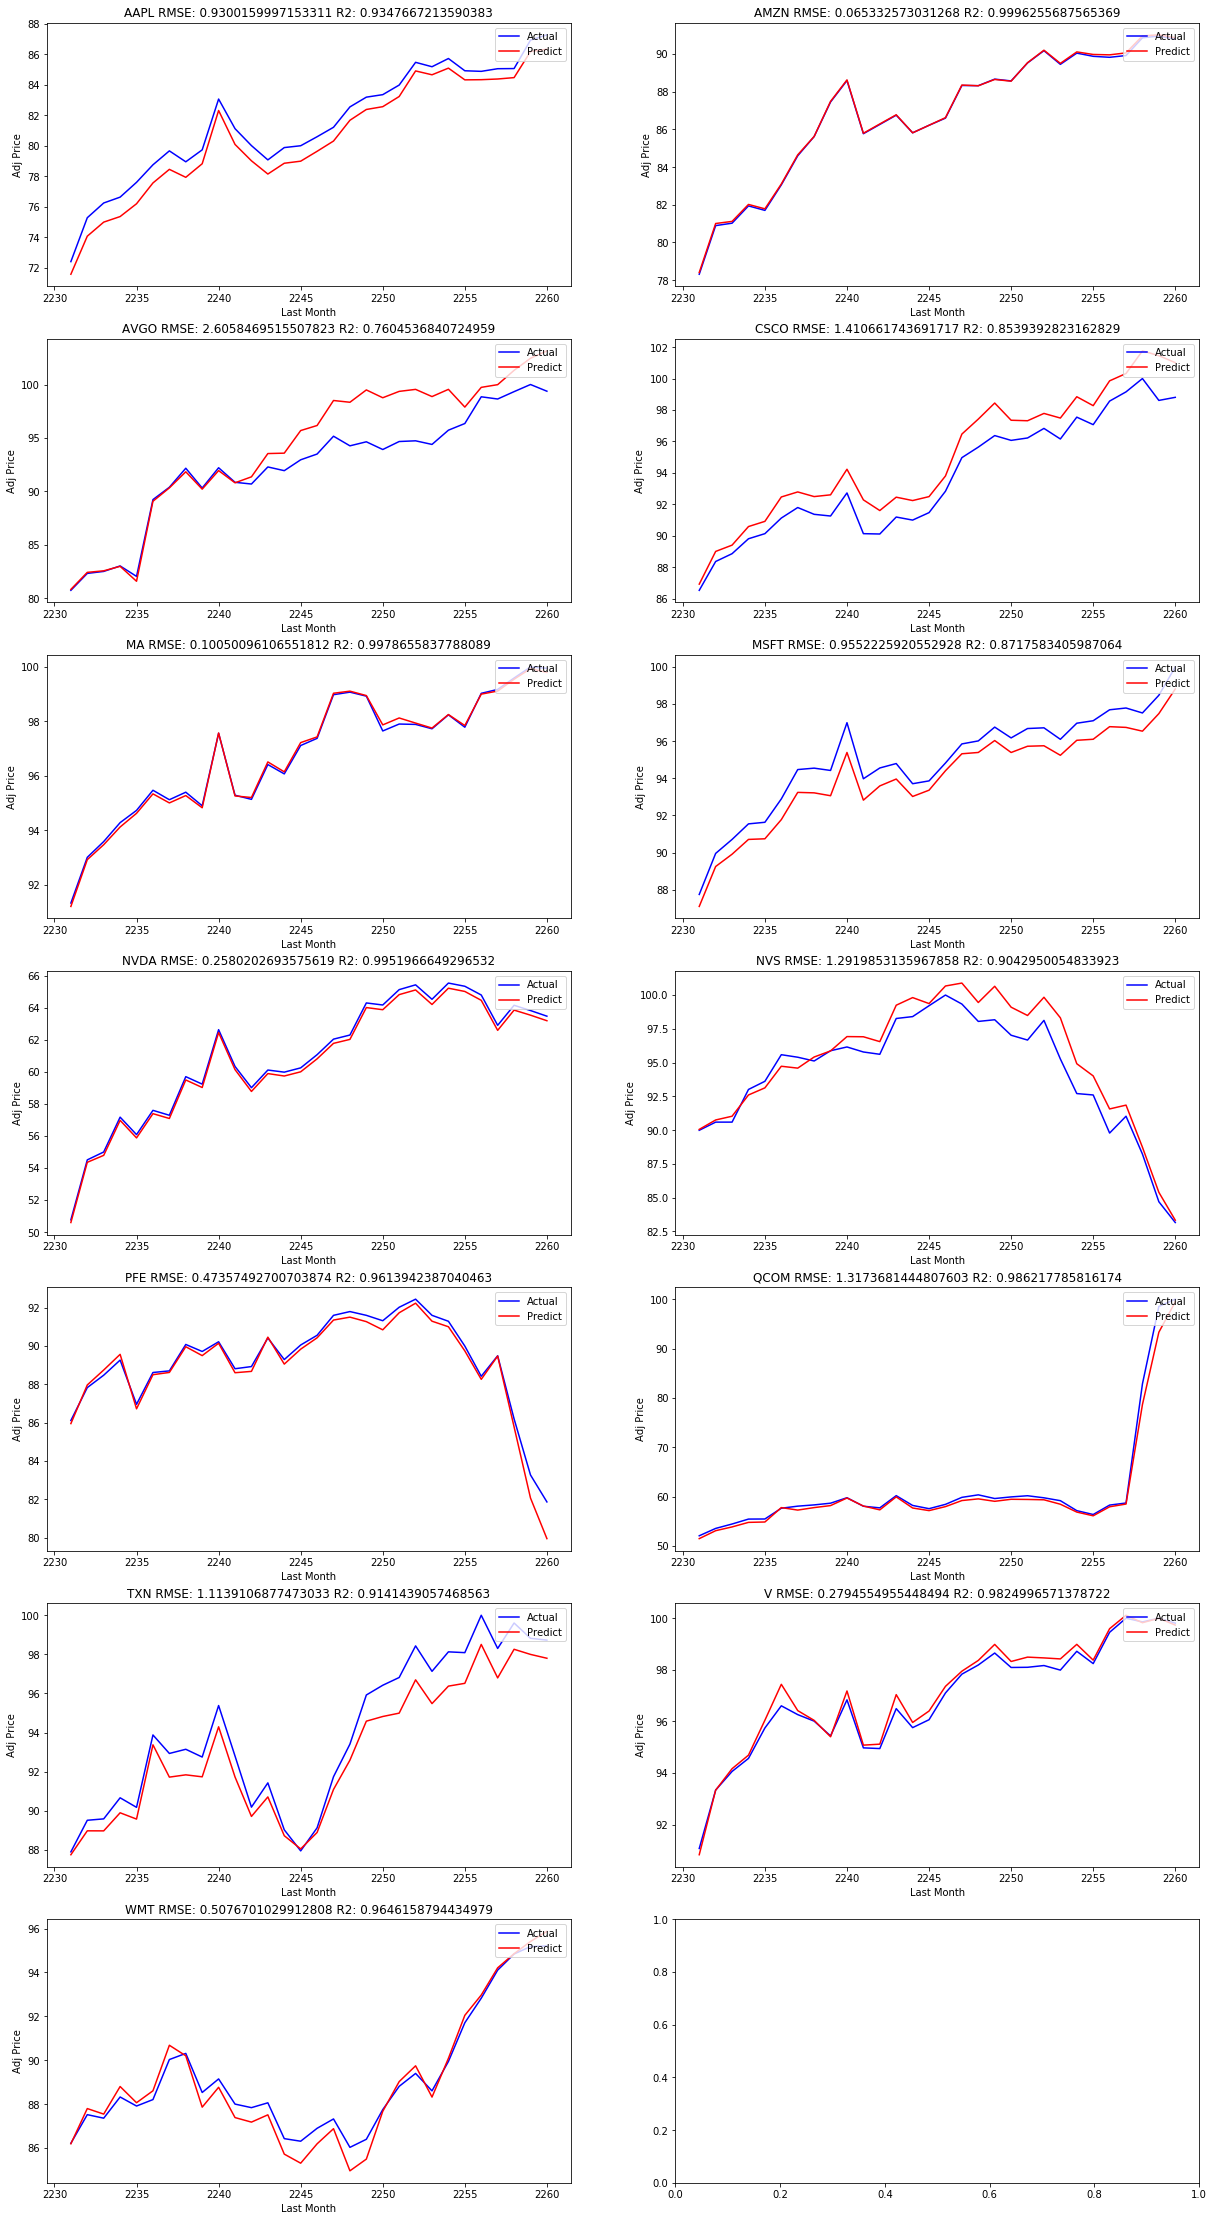

In [33]:
#plot prediction vs. real
def get_title(index, rmse_list, r2_list):
    return stock_list[index] + " RMSE: " + str(rmse_list[index]) + " R2: " + str(r2_list[index])

def plot_prediction_vs_real(actual_array, predict_array):
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 30))
    
    for i, actual in enumerate(actual_array):
        column = i % 2
        row = (i - column)/2
        row = int(row)
        axes[row][column].plot(actual_array[i].index, actual_array[i],'b', label='Actual')
        axes[row][column].plot(actual_array[i].index, predict_array[i],'r', label='Predict')
        axes[row][column].set_ylabel('Adj Price')
        axes[row][column].set_xlabel('Last Month')
        axes[row][column].legend(loc='upper right')
        axes[row][column].set_title(get_title(i,rmse_list, r2_list))
    plt.subplots_adjust(left=0.1, right=0.9, top=1.1, bottom=0.1)
    plt.show()
    

display(rmse_list)
display(r2_list)
plot_prediction_vs_real(new_y_adj_close_list, y_predict_list)


/home/ai/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


best SVR RMSE Score: 1.2720087337247223
best SVR R2 Score: 0.8779694543764894
best SVR RMSE Score: 0.9962854422845687
best SVR R2 Score: 0.9129276784552967
best SVR RMSE Score: 2.6230269379130493
best SVR R2 Score: 0.7572846809381124
best SVR RMSE Score: 1.8454319348620019
best SVR R2 Score: 0.7500324023805005
best SVR RMSE Score: 1.1088888355018955
best SVR R2 Score: 0.7401547962150932
best SVR RMSE Score: 1.2735772309669984
best SVR R2 Score: 0.7720337630395935
best SVR RMSE Score: 1.0579302772760273
best SVR R2 Score: 0.9192487362610148
best SVR RMSE Score: 1.311952230932592
best SVR R2 Score: 0.9013140119614489
best SVR RMSE Score: 0.4815940481305301
best SVR R2 Score: 0.9600757339501218
best SVR RMSE Score: 1.3026180890775012
best SVR R2 Score: 0.9865246861358663
best SVR RMSE Score: 1.2434123608491368
best SVR R2 Score: 0.8930204549352848
best SVR RMSE Score: 1.2873437748222116
best SVR R2 Score: 0.6286270026916048
best SVR RMSE Score: 0.5593897903455063
best SVR R2 Score: 0.9570

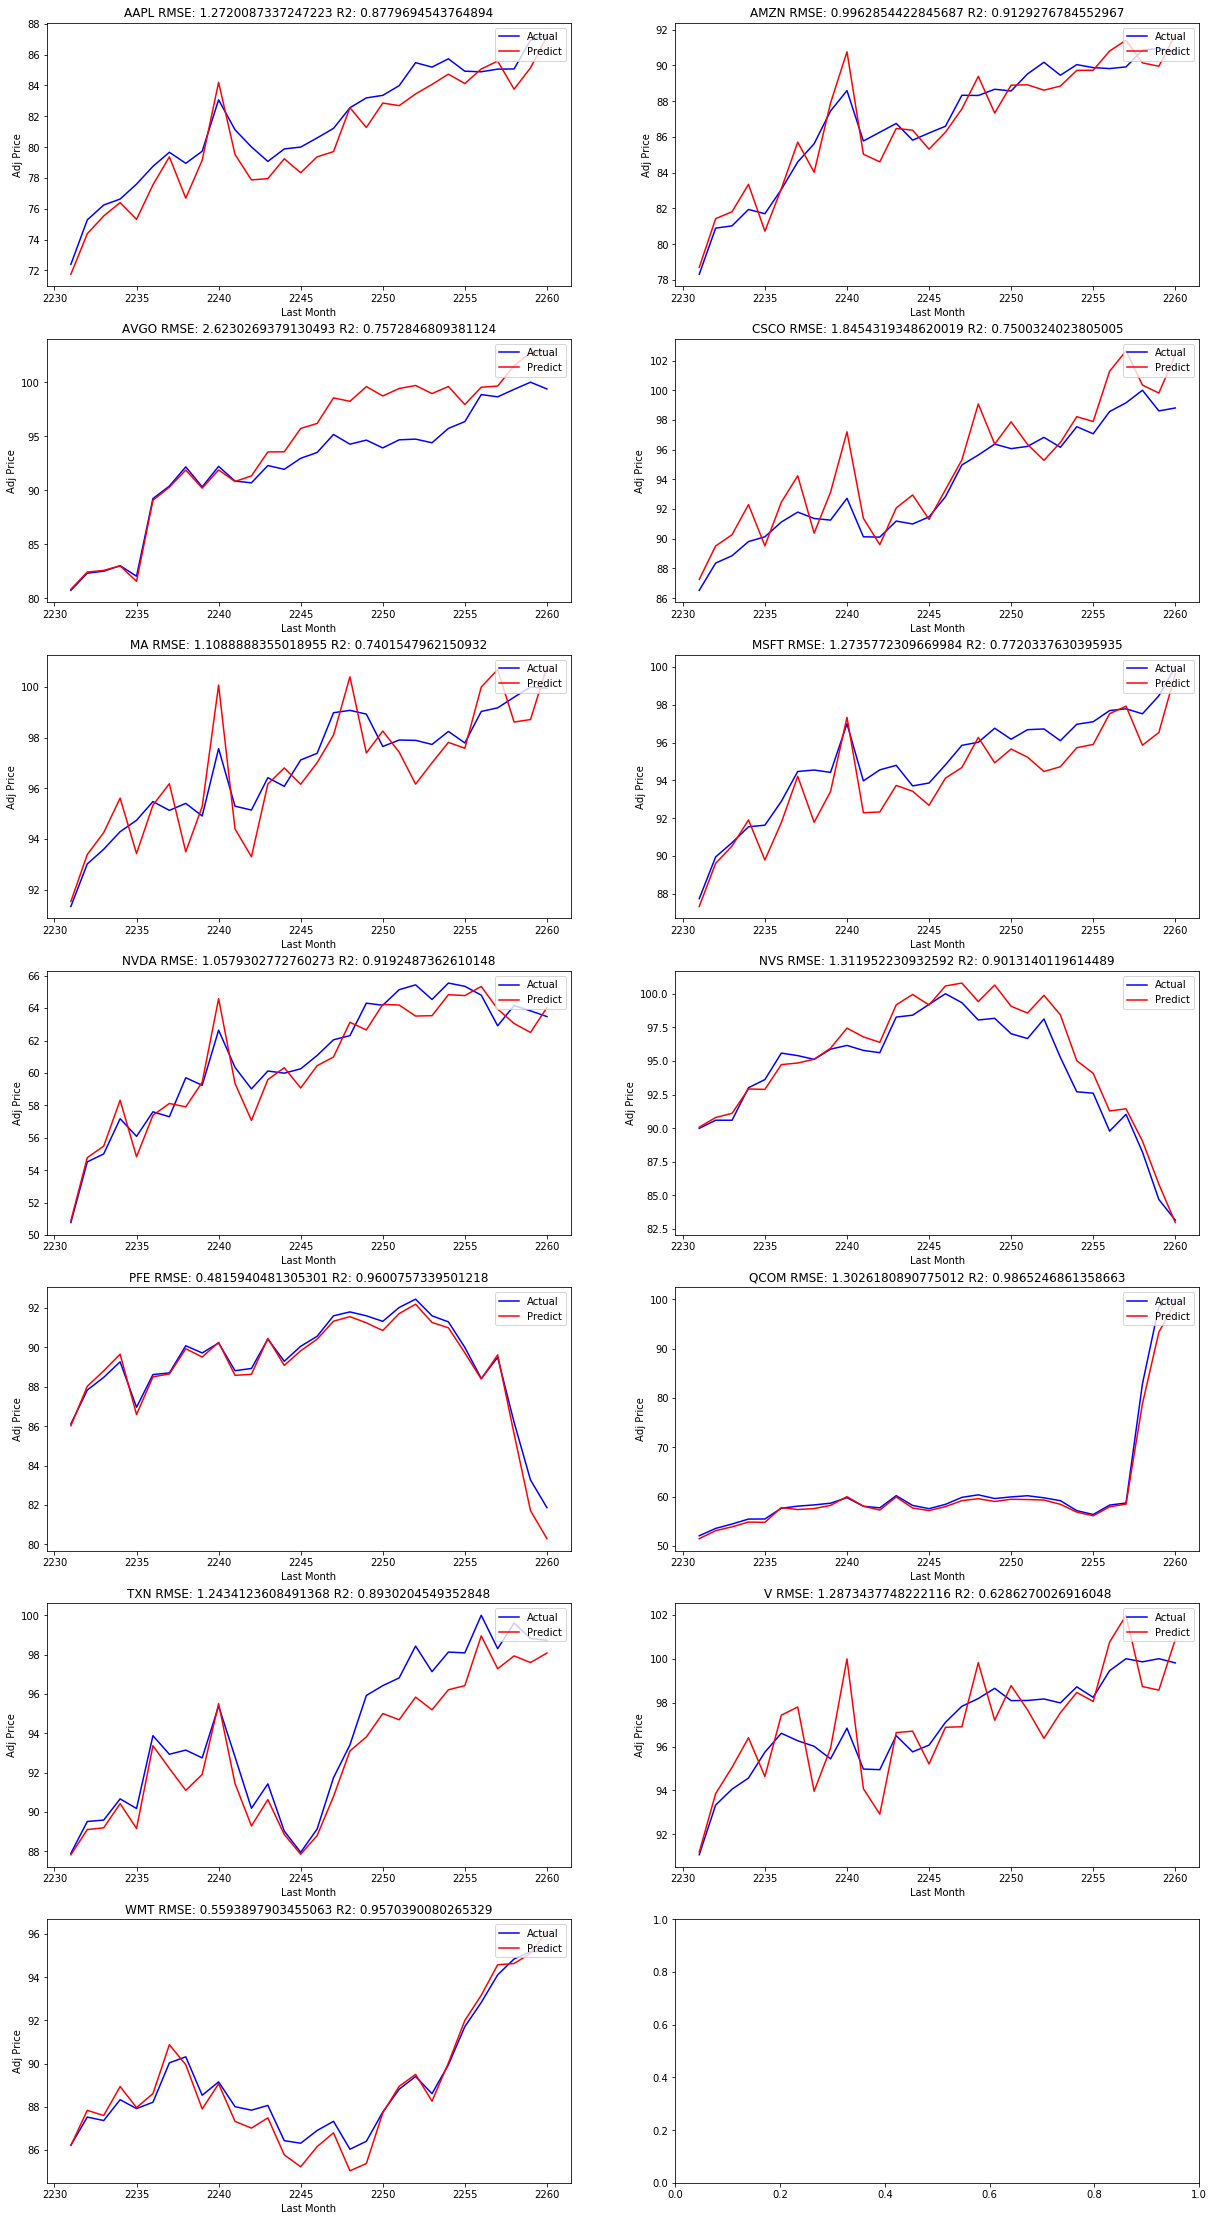

In [34]:
#apply gaussian noise to data to check for robustness of the solution
new_normalized_stock_list, new_y_adj_close_list, \
old_normalized_stock_list, old_y_adj_close_list = prepare_new_data()

noise1 = np.random.normal(0,0.005,len(new_normalized_stock_list[0]))


for index, new_stock in enumerate(new_normalized_stock_list):
    new_stock['High'] = new_stock['High'] + noise1
    new_stock['Open'] = new_stock['Open'] - noise1
    new_stock['Close'] = new_stock['Close'] + (2*noise1)
    new_normalized_stock_list[index] = new_stock

y_predict_list, rmse_list, r2_list = drive_test_4(old_normalized_stock_list, new_normalized_stock_list,old_y_adj_close_list, new_y_adj_close_list)

display(rmse_list)
display(r2_list)
plot_prediction_vs_real(new_y_adj_close_list, y_predict_list)





In [15]:
display(rmse_list)
display(r2_list)

[0.9300159997153311,
 0.065332573031268,
 2.6058469515507823,
 1.410661743691717,
 0.10050096106551812,
 0.9552225920552928,
 0.2580202693575619,
 1.2919853135967858,
 0.47357492700703874,
 1.3173681444807603,
 1.1139106877473033,
 0.2794554955448494,
 0.5076701029912808]

[0.9347667213590383,
 0.9996255687565369,
 0.7604536840724959,
 0.8539392823162829,
 0.9978655837788089,
 0.8717583405987064,
 0.9951966649296532,
 0.9042950054833923,
 0.9613942387040463,
 0.986217785816174,
 0.9141439057468563,
 0.9824996571378722,
 0.9646158794434979]